# Notebook 1 : UK data analysis + LDA  :

In [5]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. the UK data exploration:

## 1.1. Importing the data 

In [6]:
news = pd.DataFrame()
DATA_FILES = ['uk/newspaper.json']
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)
news.head()

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
0,The harlequin ladybird is a clever little devil,"Wenlock Edge, Shropshire Used to control crop ...","[Paul Evans, Peter Brown, Helen Roy]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,"[Insects, Invasive species, Rural affairs, Aut...",GER_2019-03-15_37_web_page.html,www.theguardian.com/environment/2016/nov/02/vo...,NaN,uk
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk
2,Page not found,Cheer up. It's not the end of the world...\n\n...,None,"[data:image/jpeg;base64,/9j/4QAYRXhpZgAASUkqAA...",None,en,[],GER_2019-03-15_487_web_page.html,www.channel4.com/programmes/catchup/2019/03/14/e4,NaN,uk
3,Young Sheldon,None,None,[https://ic.c4assets.com/brands/brooklyn-nine-...,None,en,[],GER_2019-03-15_488_web_page.html,www.channel4.com/programmes/young-sheldon/on-d...,NaN,uk
4,Sign in,Uncheck if you're using a shared or public com...,None,None,None,en,[],GER_2019-03-15_489_web_page.html,4id.channel4.com/login?redirectUrl=https://www...,NaN,uk


## 1.2. Filter the english articles only 

In [7]:
news = news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] 

* We got 118487 preliminary records.

## 1.3. Url domain/ subdomains identification / Integrating the known working domains 

In [8]:
import tldextract
news['domain'] = news['url'].apply (lambda row: tldextract.extract(row).domain+"."+tldextract.extract(row).suffix)
news['subdomain'] = news['url'].apply (lambda row: tldextract.extract(row).subdomain)

In [9]:
#list with media domains
domains_path = '../iboeckmann/webtracking_analysis/parsing/data/domaincodes/domaincodes.csv'
news_domains = pd.read_csv(domains_path)
news_domains

,domain,type,comm_pol
0,dailymail.co.uk,Tabloid newspaper,NaN
1,rai.it,Public broadcaster,NaN
2,reuters.com,Quality newspaper/magazine,NaN
3,abc.es,Quality newspaper/magazine,NaN
4,20minutos.es,Tabloid newspaper,NaN
...,...,...,...
537,resistancerepublicaine.eu,Hyperpartisan media,NaN
538,paris-normandie.fr,Quality newspaper/magazine,NaN
539,epochtimes.fr,Hyperpartisan media,NaN
540,epochtimes.de,Hyperpartisan media,NaN


In [10]:
#checking how many unique domains in the uk dataset
print(len(news.domain.unique()))
news.domain.unique()

258


array(['theguardian.com', 'sky.com', 'channel4.com', 'metro.co.uk',
       'reuters.com', 'msnbc.com', 'bbc.co.uk', 'thesun.co.uk', 'cnn.com',
       'dailymail.co.uk', 'itv.com', 'abc.net.au', 'mirror.co.uk',
       'telegraph.co.uk', 'standard.co.uk', 'dpreview.com', 'bbc.com',
       'independent.co.uk', 'express.co.uk', 'buzzfeednews.com',
       'theconversation.com', 'plymouthherald.co.uk', 'nbc.com',
       'indiatimes.com', 'usatoday.com', 'nypost.com', 'bostonglobe.com',
       'rockpapershotgun.com', 'gamespot.com', 'rte.ie', 'fox.com',
       'thetimes.co.uk', 'android.com', 'thetelegraphandargus.co.uk',
       'dailystar.co.uk', 'derbytelegraph.co.uk', 'wired.com',
       'kentonline.co.uk', 'ndtv.com', 'liveleak.com', 'uktv.co.uk',
       'sfgate.com', 'bustle.com', 'cosmopolitan.com',
       'trinitymirror-news.co.uk', 'newsnow.co.uk', 'news.com.au',
       'thedailybeast.com', 'buzzfeed.com', 'dailyrecord.co.uk',
       'eveningtimes.co.uk', 'timesofisrael.com', 'der-pos

In [11]:
#how many of those unique urls are recognised newspapers ?
print(len(set(news.domain.unique()).intersection(set(news_domains.domain))))
set(news.domain.unique()).intersection(set(news_domains.domain))

192


{'20minutes.fr',
 'abc.es',
 'abc.net.au',
 'abc13.com',
 'abc15.com',
 'abc7.com',
 'abc7chicago.com',
 'abc7ny.com',
 'abcactionnews.com',
 'abcn.ws',
 'adnkronos.com',
 'aljazeera.com',
 'apnews.com',
 'arcamax.com',
 'atresplayer.com',
 'baltimoresun.com',
 'bbc.co.uk',
 'bbc.com',
 'bloomberg.com',
 'bostonglobe.com',
 'breitbart.com',
 'businessinsider.com',
 'buzzfeed.com',
 'buzzfeednews.com',
 'cbc.ca',
 'cbs.com',
 'cbslocal.com',
 'cbsnews.com',
 'ccma.cat',
 'channel4.com',
 'cnbc.com',
 'cnn.com',
 'cnn.it',
 'dailykos.com',
 'dailymail.co.uk',
 'dailyrecord.co.uk',
 'dailystar.co.uk',
 'dailywire.com',
 'dallasnews.com',
 'daytondailynews.com',
 'democratandchronicle.com',
 'denverpost.com',
 'derbytelegraph.co.uk',
 'diariodesevilla.es',
 'dw.com',
 'economist.com',
 'elmundo.es',
 'elpais.com',
 'elperiodico.com',
 'euronews.com',
 'europe1.fr',
 'eveningtimes.co.uk',
 'express.co.uk',
 'expressandstar.com',
 'firstcoastnews.com',
 'fivethirtyeight.com',
 'forbes.com',


* We got a list of 542 working domains. Out of which, we found 192 in the uk dataset that had 258 total domains.

## 1.4. Drop the Nan values from both 'text' and 'title' columns :

In [12]:
#filtering the unnecessary domains 
media_portals = news[news['domain'].isin(news_domains['domain'].values)]
media_portals=media_portals.dropna(subset=['text','title'])  
media_portals.reset_index(inplace=True, drop=True)

* We got 95776 records after dropping rows with inexistent values

## 1.5. Checking the number of occurences of articles based on title and text seperately :

In [14]:
text_counts = pd.DataFrame(media_portals.text.value_counts())
print(len(text_counts[text_counts['text']<30]))
text_counts[text_counts['text'].between(20,30)]

62699


,text
"To view this video please enable JavaScript, and consider upgrading to a web browser that supports HTML5 video",30
1\n\nClick\n\nto allow notifications\n\nfrom RTÉ,30
"7 Everlasting cross goes inside and outside (8)\n\n9 A group of directors on a ship (6)\n\n10 Funny thing, the sound of an owl (4)\n\n11 Thoughtless fat man on throne? (10)\n\n12 Saint having last word in prayer? That's a bit of a bloomer (6)\n\n14 Doctor Who following teams — not the main event (8)\n\n15 Monster devouring old mounted soldier (7)\n\n17 Red nose turning back (7)\n\n20 Matins, as sort of devil worship (8)\n\n22 Less experienced party leader brought back before September 1939? (3-3)\n\n23 Translation of annual said to be Spanish (10)\n\n24 Drink kept in percolator (4)\n\n25 Tree abandoned after heading off for Sex and the City (6)",30
Please update your billing information\n\nThe subscription details associated with this account need to be updated. Please update your billing details here to continue enjoying your subscription.,28
"The desperate pleas of asylum seekers who ""Remain in Mexico""",28
"APPLAUSE was heard across the East End today as Celtic fans bid an emotional farewell to another of their greatest heroes.\n\nStevie Chalmers’ funeral cortege passed by Celtic Park for the last time on Wednesday afternoon.\n\nSupporters gathered at the ground in their numbers five days after thousands turned out to pay their last respects to Chalmers' former captain, Billy McNeill.\n\nStevie Chalmers funeral as it happened: Glasgow's farewell to second Lisbon Lion in a week\n\nThe forward scored the most important goal in Celtic's history, the 1967 European Cup final winner against Inter Milan, one of 231 he netted for the club.\n\nA funeral mass took place in Calton, near Parkhead, for Chalmers, who died aged 83 last week after suffering from dementia in recent years.\n\nThe service took place at 11.30am at St Mary's Church, where Celtic Football Club was first established during a meeting in 1887.\n\nNeil Lennon, Sir Alex Ferguson, the Celtic squad and the remaining Lisbon Lions were all in attendance.\n\nArchbishop Philip Tartaglia told the congregation: “I offer our sympathies to the Celtic family. He was, of course, one of the incomparable Lisbon Lions who won the European Cup. Stevie had the tremendous distinction of scoring the winning goal.\n\nREAD MORE: Celtic submit plans to parade through Glasgow following treble treble win\n\n“Stevie’s family say his priorities in life we his faith, family and football. That is surely a fitting legacy.\n\n“Stevie and Billy’s names have become synonymous over the past two days. This has been a distressing time for their families.\n\n“You could not hope to meet two different men. And yet, as we all know, there was something that joined them together - and it was how their lives came to an end.\n\n“To score the winning goal earned him the right to say he scored the most important goal in the history of Scottish football. He was proud to score that goal, but to him it was more important that the team won.\n\nFor all your breaking Glasgow news, click here, or head to our Facebook, Twitter and Instagram pages\n\n“What Stevie did that day in Lisbon had an affect on the whole nation. Nobody was really convinced a team from Scotland could be kings. It gave the country a whole new set of aspirations.”\n\nAfter the service, the cortege then passed through the Celtic Way just after 1pm to rapturous applause before going onto a private family cremation.\n\nCeltic Football Club described Chalers as “the man who scored the most important goal in the club's history.”",28
News... but not as you know it,27
1 Permit to do something (6)\n\n4 Potential oaks? (6)\n\n8 Put down on paper (5)\n\n9 Dominance (7)\n\n10 Vehicle seen on the roads in wintery conditions (7)\n\n11 Synthetic silk-like fabric (5)\n\n12 Bogus trap (anag) — somewhere good to eat and drink? (9)\n\n17 Ghastly (5)\n\n19 Convey (7)\n\n21 Out of order — errati

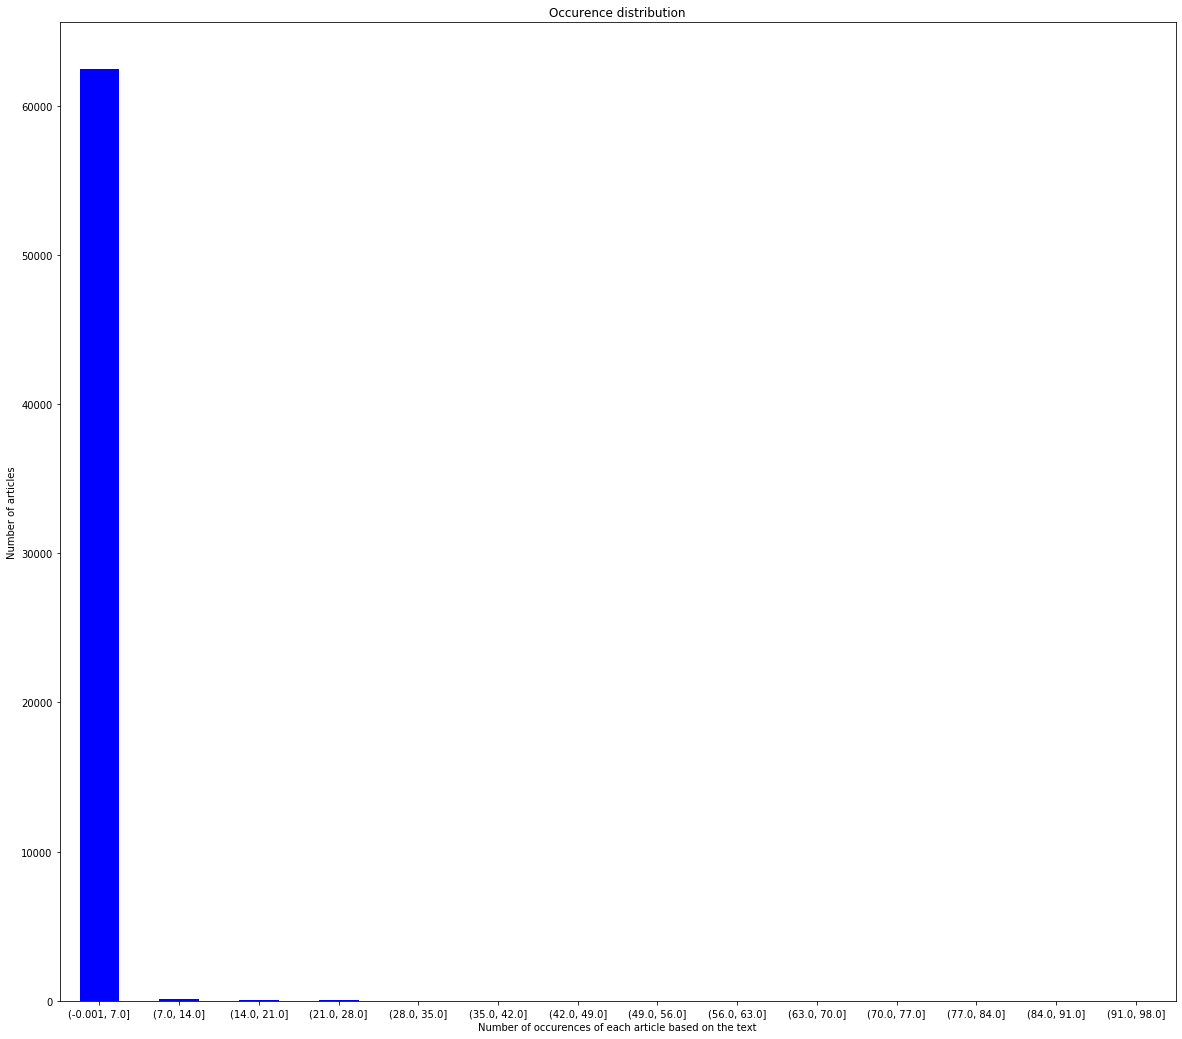

In [19]:
out = pd.cut(text_counts['text'], bins=list(range(0,100,7)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(20,18))
plt.ylabel('Number of articles')
plt.xlabel('Number of occurences of each article based on the text')
plt.title("Occurence distribution")
plt.show()

In [17]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())
print("the pearson correlation coefficient between the occurences of titles agaisnt occurences of texts is of " + str(media_portals['title_counts'].corr(media_portals['txt_counts'])))

the pearson correlation coefficient between the occurences of titles agaisnt occurences of texts is of 0.7094232222994535


In [12]:
#s=media_portals[media_portals["authors"].isna()]
criteria=7
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 7 :76058
Number of articles with title occurence less than 7 :76071
Number of articles with title and text occurence combined less than 7 :72203


* In my effort to make sense of the articles’ maximum occurrence  number (7 in our case) to be taken in the analysis, I managed to find some articles with considerably high number of occurrences (my theory is that they are pop-ups but still we should include them)


* You can play around with criteria which represents the maximum occurrence number

In [13]:
s['text_id'] = s.groupby('text', sort=False).ngroup()
s['title_id'] = s.groupby('title', sort=False).ngroup()

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
s

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,domain,subdomain,txt_counts,title_counts,text_id,title_id
0,The harlequin ladybird is a clever little devil,"Wenlock Edge, Shropshire Used to control crop ...","[Paul Evans, Peter Brown, Helen Roy]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,"[Insects, Invasive species, Rural affairs, Aut...",GER_2019-03-15_37_web_page.html,www.theguardian.com/environment/2016/nov/02/vo...,NaN,uk,theguardian.com,www,1,1,0,0
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,sky.com,news,1,1,1,1
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,metro.co.uk,,2,2,2,2
3,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,metro.co.uk,,2,2,2,2
4,"Forty killed, more than 20 injured in New Zeal...",An injured person is loaded into an ambulance ...,"[Reuters Editorial, Min Read]",[http://static.reuters.com/resources_v2/react/...,None,en,"[US, NEWZEALAND, SHOOTOUT, TOLL, General News,...",GER_2019-03-15_1077_web_page.html,www.reuters.com/article/us-newzealand-shootout...,NaN,uk,reuters.com,www,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72198,"Mother Jones – Smart, fearless journalism",Can you pitch in a few bucks to help fund Moth...,"[Johann Groder Apa Picturedesk Via Zuma Press,...",[https://www.motherjones.com/wp-content/upload...,None,en,[],GER_2019-06-15_2120_mobile_.html,www.motherjones.com/,NaN,uk,motherjones.com,www,1,1,59794,58017
72199,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,metro.co.uk,,1,1,59795,58018
72200,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59796,58019
72201,Amazon Echo is FREE is this new deal as 15 new...,Amazon Echo is now free in this latest deal\n\...,[David Snelling],[https://cdn.images.express.co.uk/img/page/pla...,None,en,[],GER_2019-06-15_4601_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59797,58020


# 2. Data preprocessing :

In [15]:
a=s

## 2.1. Dropping duplicates for the sake of model accuracy

In [16]:
a.drop_duplicates(subset='text', keep='first')

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,domain,subdomain,txt_counts,title_counts,text_id,title_id
0,The harlequin ladybird is a clever little devil,"Wenlock Edge, Shropshire Used to control crop ...","[Paul Evans, Peter Brown, Helen Roy]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,"[Insects, Invasive species, Rural affairs, Aut...",GER_2019-03-15_37_web_page.html,www.theguardian.com/environment/2016/nov/02/vo...,NaN,uk,theguardian.com,www,1,1,0,0
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,sky.com,news,1,1,1,1
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,metro.co.uk,,2,2,2,2
4,"Forty killed, more than 20 injured in New Zeal...",An injured person is loaded into an ambulance ...,"[Reuters Editorial, Min Read]",[http://static.reuters.com/resources_v2/react/...,None,en,"[US, NEWZEALAND, SHOOTOUT, TOLL, General News,...",GER_2019-03-15_1077_web_page.html,www.reuters.com/article/us-newzealand-shootout...,NaN,uk,reuters.com,www,1,1,3,3
5,Apple says Spotify wants benefits of a free ap...,(Reuters) - Apple Inc on Thursday responded to...,"[Reuters Editorial, Min Read]",[http://static.reuters.com/resources_v2/react/...,None,en,"[US, APPLE, SPOTIFY, TECH, EU, Anti, competiti...",GER_2019-03-15_1078_web_page.html,www.reuters.com/article/us-apple-spotify-tech-...,NaN,uk,reuters.com,www,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72198,"Mother Jones – Smart, fearless journalism",Can you pitch in a few bucks to help fund Moth...,"[Johann Groder Apa Picturedesk Via Zuma Press,...",[https://www.motherjones.com/wp-content/upload...,None,en,[],GER_2019-06-15_2120_mobile_.html,www.motherjones.com/,NaN,uk,motherjones.com,www,1,1,59794,58017
72199,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,metro.co.uk,,1,1,59795,58018
72200,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59796,58019
72201,Amazon Echo is FREE is this new deal as 15 new...,Amazon Echo is now free in this latest deal\n\...,[David Snelling],[https://cdn.images.express.co.uk/img/page/pla...,None,en,[],GER_2019-06-15_4601_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59797,58020


## 2.2. Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [18]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [19]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

## 2.3. stemming + Lemmatization 

In [20]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

## 2.4. Lowercase + Tokenization

In [21]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

## 2.5. Stopwords deletion 

In [22]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [23]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [24]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))
#a['clean_title']=a['title'].apply(lambda x: clean_text(str(x)))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
a['length']=a['clean_text'].apply(lambda x: len(x))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,domain,subdomain,txt_counts,title_counts,text_id,title_id,clean_text,length
0,The harlequin ladybird is a clever little devil,"Wenlock Edge, Shropshire Used to control crop ...","[Paul Evans, Peter Brown, Helen Roy]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,"[Insects, Invasive species, Rural affairs, Aut...",GER_2019-03-15_37_web_page.html,www.theguardian.com/environment/2016/nov/02/vo...,NaN,uk,theguardian.com,www,1,1,0,0,"[wenlock, edg, shropshir, control, crop, pest,...",182
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,sky.com,news,1,1,1,1,"[imag, man, lay, flower, victim, terror, attac...",9
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,metro.co.uk,,2,2,2,2,"[australian, senat, provok, outrag, blame, isl...",302
3,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,metro.co.uk,,2,2,2,2,"[australian, senat, provok, outrag, blame, isl...",302
4,"Forty killed, more than 20 injured in New Zeal...",An injured person is loaded into an ambulance ...,"[Reuters Editorial, Min Read]",[http://static.reuters.com/resources_v2/react/...,None,en,"[US, NEWZEALAND, SHOOTOUT, TOLL, General News,...",GER_2019-03-15_1077_web_page.html,www.reuters.com/article/us-newzealand-shootout...,NaN,uk,reuters.com,www,1,1,3,3,"[injur, person, load, ambul, shoot, al, noor, ...",43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72198,"Mother Jones – Smart, fearless journalism",Can you pitch in a few bucks to help fund Moth...,"[Johann Groder Apa Picturedesk Via Zuma Press,...",[https://www.motherjones.com/wp-content/upload...,None,en,[],GER_2019-06-15_2120_mobile_.html,www.motherjones.com/,NaN,uk,motherjones.com,www,1,1,59794,58017,"[pitch, buck, fund, mother, jone, investig, jo...",24
72199,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,metro.co.uk,,1,1,59795,58018,"[ian, wright, open, warn, children, come, raci...",285
72200,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59796,58019,"[amazon, echo, voic, call, vodafon, deal, amaz...",160
72201,Amazon Echo is FREE is this new deal as 15 new...,Amazon Echo is now free in this latest deal\n\...,[David Snelling],[https://cdn.images.express.co.uk/img/page/pla...,None,en,[],GER_2019-06-15_4601_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,express.co.uk,www,1,1,59797,58020,"[amazon, echo, free, latest, deal, amazon, ech...",248


# 3. LDA model 

## 3.1. Preparing LDA ingredients

In [27]:
data_lemmatized = a['clean_text']

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=30, no_above=0.5)

# Create Corpus
texts = data_lemmatized

In [29]:
id2word 

In [30]:
# Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

## 3.2. Incorporating Tf-Idf + building the model + computing coherence score

In [31]:
tfidf = models.TfidfModel(bow_corpus,normalize =True)
corpus = tfidf[bow_corpus]

In [32]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 18202
Number of documents: 72203


In [34]:
# Build LDA model
numberoftopics=[18,19,20]

for i in numberoftopics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= i , 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=1000,
                                                   passes=2,
                                                   alpha='auto',
                                                   per_word_topics=True)
    print("------------------------------------------------")
    print("number of topics" , i)
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))
    print(lda_model.print_topics())
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    # Plotting tools
    import pyLDAvis
    import pyLDAvis.gensim  # don't skip this
    import matplotlib.pyplot as plt
    %matplotlib inline


    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    vis


------------------------------------------------
number of topics 18

Perplexity:  -11.270037279417332
[(0, '0.020*"sander" + 0.018*"broadband" + 0.017*"nicol" + 0.016*"gogglebox" + 0.014*"elton" + 0.014*"everton" + 0.014*"frontrunn" + 0.014*"jenni" + 0.013*"protein" + 0.012*"valeri"'), (1, '0.025*"fibr" + 0.024*"maya" + 0.018*"bake" + 0.016*"cha" + 0.015*"leicestershir" + 0.015*"dryer" + 0.013*"xbox" + 0.013*"louisa" + 0.012*"flour" + 0.012*"microsoft"'), (2, '0.007*"girl" + 0.007*"death" + 0.006*"murder" + 0.006*"woman" + 0.006*"hospit" + 0.006*"daughter" + 0.006*"health" + 0.006*"die" + 0.005*"mother" + 0.005*"life"'), (3, '0.020*"korean" + 0.019*"jen" + 0.018*"harper" + 0.014*"monthli" + 0.014*"cheshir" + 0.014*"theft" + 0.013*"luther" + 0.012*"hurrican" + 0.012*"lavish" + 0.012*"jong"'), (4, '0.068*"hull" + 0.056*"password" + 0.042*"exam" + 0.026*"warrington" + 0.020*"communist" + 0.016*"breezi" + 0.015*"sutton" + 0.011*"iceland" + 0.010*"workout" + 0.010*"ofst"'), (5, '0.016*"mel

## 3.3. this part is related to chapter 1.5.

* I included this part to give an obvious example of why we should rely on article occurence for filtering 

In [26]:
title_counts = pd.DataFrame(media_portals.title.value_counts().head(300))

In [27]:
title_counts

,title
NewsNow: Error loading story,2475
HuffPost is now part of Oath,824
BBC iPlayer,811
Survey closed,674
BBC Weather,645
...,...
Hypothetical on UKTV Play,12
Yorkshire breaking news: Latest updates,12
Sky Q experience - Multi-room & Ultra HD TV experience,12
"Sky Broadband & TV Deals - Broadband, TV & Talk Packages",12


In [28]:
news[news['title']=='NewsNow: Error loading story']

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,domain,subdomain
519,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-03-15_33209_web_page.html,c.newsnow.co.uk/A/977712561?-19388:814:most_re...,NaN,uk,newsnow.co.uk,c
520,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-03-15_33210_web_page.html,c.newsnow.co.uk/A/977712561?-19388:814:most_re...,NaN,uk,newsnow.co.uk,c
522,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-03-15_33212_web_page.html,c.newsnow.co.uk/A/977692707?-19388:814:most_re...,NaN,uk,newsnow.co.uk,c
523,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-03-15_33213_web_page.html,c.newsnow.co.uk/A/977692707?-19388:814:most_re...,NaN,uk,newsnow.co.uk,c
524,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-03-15_33215_web_page.html,c.newsnow.co.uk/A/977691949?-19388:814:most_re...,NaN,uk,newsnow.co.uk,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119945,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-06-15_44181_web_page.html,c.newsnow.co.uk/A/989132318?-11344:801:most_re...,NaN,uk,newsnow.co.uk,c
119946,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-06-15_44183_web_page.html,c.newsnow.co.uk/A/989113430?-11344:801:most_re...,NaN,uk,newsnow.co.uk,c
119947,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-06-15_44184_web_page.html,c.newsnow.co.uk/A/989113430?-11344:801:most_re...,NaN,uk,newsnow.co.uk,c
119948,NewsNow: Error loading story,"Sorry\n\nSorry, you clicked a link to an artic...",None,[http://fox13now.com/ico/retrieval_branding--2...,None,None,[],GER_2019-06-15_44186_web_page.html,c.newsnow.co.uk/A/989134564?-11344:801:most_re...,NaN,uk,newsnow.co.uk,c


In [ ]:
media_portals['text_len'] = media_portals['text'].apply(lambda x: len(str(x).split()) if x else np.nan)
media_portals_clean = media_portals[~media_portals['text_len'].isnull()].copy() #omitting those rows where text is empty
media_portals_clean

## 3.4. Text length distribution 

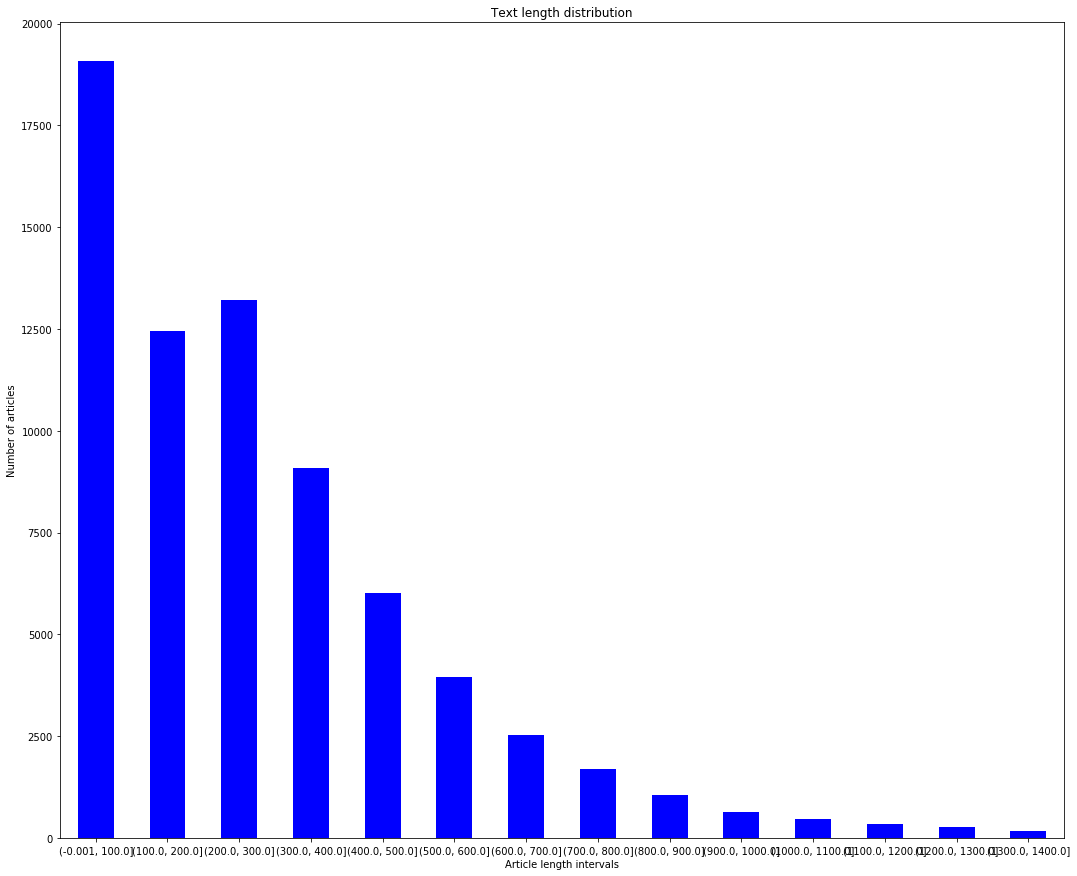

In [122]:
import matplotlib.pyplot as plt
out = pd.cut(a['text_length'], bins=list(range(0,1500,100)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(18,15))
plt.ylabel('Number of articles')
plt.xlabel('Article length intervals')
plt.title("Text length distribution")
plt.show()

In [131]:
a=[lda_model]

Text(0.5, 1.0, 'Coherence score in function of the number of topics')

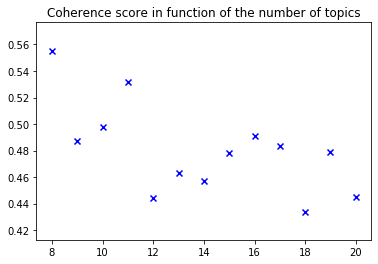

In [39]:
import matplotlib.pyplot as plt
x=[8,9,10,11,12,13,14,15,16,17,18,19,20]
y= [0.5554375906099775,0.48743052120495683,0.49810749794853215,0.5319898924807671,0.4444701445005274,0.4628595543755662,0.45724783472835273,0.4779877585441481,0.4912625211129416,0.48364511157262946,0.4339832231708188,0.4791802221559691,0.4453575710214375]
z=[-9.141746589925553,-9.205309739953213,-9.455347063936431,-9.847306801658492,-10.206954381300992,-10.420951842914306,-10.650871745524869,-10.799037082202519,-10.925523233811269,-11.107912722497504,-11.270037279417332,-11.363312439972303,-11.645276495330531]
plt.scatter(x,y, c='b', marker='x', label='coherence score')
plt.title(label='Coherence score in function of the number of topics')


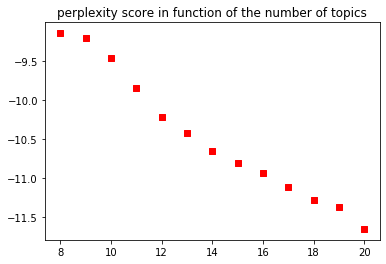

In [40]:
plt.scatter(x, z, c='r', marker='s', label='perplexity score')
plt.title(label='perplexity score in function of the number of topics')
plt.show()

* from the results, combining Tfidf with LDA generates less coherence in the results (that are mainly non-interpretable). After some digging on the internet, I found out that It is recommended not to combine the two. To explain, tf-idf gives a certain weight ( word_score_1) per word and LDA gives another weight per word w.r.t. a particular topic (word_score_2),what the model does is that it multiplies word_score_1 and word_score_2 for a particular word in a particular topic. And since  tf-idf gives common words lower weights, multiplying will give priority to unique words over common words.  That’s why we find for example: when number of topics = 8, the keywords of the first topic are mainly names that are irrelevant to us and cannot be interpretable. 